In [ ]:
!pip install Sastrawi

     |████████████████████████████████| 209 kB 4.3 MB/s 


# Import Library

In [ ]:
import csv
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import confusion_matrix, classification_report
from google_drive_downloader import GoogleDriveDownloader as gdd
from sklearn import preprocessing
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Truth Discovery

In [ ]:
class TruthDiscovery():
  def __init__(self):
    self.dataframe = pd.DataFrame()

  def one_hot_encoding(self, source_list, claim_list, df):
    scores = []
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    for sr in source_list:
      s = []
      for c in claim_list:
        w = c.split()
        r = stemmer.stem(w[0]) + '(.*?)' + stemmer.stem(w[1]) if len(w)>1 else c
        df_sr = df[df["source_url"] == sr]
        if len(df_sr[df_sr['idiom_claims'].str.contains(r, na=False)])!=0:
          s.append(1)
        else:
          s.append(0)
      scores.append(s)
    claim = pd.DataFrame(scores, columns=claim_list)
    source = pd.DataFrame([[s] for s in source_list], columns=['source_url'])
    data_score = pd.concat([source, claim], axis=1)
    return scores, data_score

  def calculate_cs_score(self, scores):
    Cs_count_list = []
    for i in scores:
      Cs = 0
      for j in i:
        if j == 1:
          Cs = Cs + 1
      Cs_count_list.append(Cs)
    return Cs_count_list

  def inisialisasi_claim_value(self, factor, scores):
    new_scores = scores
    for i in range(len(new_scores)):
      for j in range(len(new_scores[0])):
        new_scores[i][j] *= factor
    return new_scores

  def calculate_trustworthiness_score(self, Cs_count_list, new_scores, isAvgLog):
    trustworthiness_score_list = []
    for i in range(len(new_scores)):
      trustworthiness_score = 0
      for j in range(len(new_scores[i])):
        trustworthiness_score = trustworthiness_score + new_scores[i][j]
        
      if(isAvgLog):
        trustworthiness_score = (math.log(Cs_count_list[i]))*(trustworthiness_score/Cs_count_list[i])

      trustworthiness_score_list.append(trustworthiness_score)

      for j in range(len(new_scores[i])):
        if new_scores[i][j] > 0:
          new_scores[i][j] = trustworthiness_score
    return trustworthiness_score_list, new_scores

  def calculate_belief_score(self, new_scores):
    belief_score_list = []
    for i in range(len(new_scores[0])):
      belief_score = 0
      for j in range(len(new_scores)):
        belief_score = belief_score + new_scores[j][i]
        
      belief_score_list.append(belief_score)

      for j in range(len(new_scores)):
        if new_scores[j][i] > 0:
          new_scores[j][i] = belief_score
    return belief_score_list, new_scores

  def set_trustworthiness_score(self, df, source_list, trustworthiness_score_list):
    index = df.index
    index_column = df.columns.get_loc('trustworthiness_score')
    for i in range(len(source_list)):
      condition = df['source_url'] == source_list[i]
      indices = index[condition].tolist()
      df.iloc[indices,[index_column]] = trustworthiness_score_list[i]
    df['trustworthiness_score']=(df['trustworthiness_score']/df['trustworthiness_score'].mean())
    return df

  def set_belief_score(self, df, claim_list, belief_score_list):
    index = df.index
    index_column = df.columns.get_loc('belief_score')
    for i in range(len(claim_list)):
      condition = df['idiom_claims'] == claim_list[i]
      indices = index[condition].tolist()
      df.iloc[indices,[index_column]] = belief_score_list[i]
    df['belief_score']=(df['belief_score']/df['belief_score'].mean())
    return df

  def fit(self, df, factor, isAvgLog, iteration):
    source_list = df["source_url"].drop_duplicates().values.tolist()
    claim_list = df["idiom_claims"].drop_duplicates().values.tolist()

    tabel_scores = self.one_hot_encoding(source_list, claim_list, df)[0]
    Cs_count_list = self.calculate_cs_score(tabel_scores)
    new_scores = self.inisialisasi_claim_value(factor, tabel_scores)
    
    trustworthiness_score_list = []
    belief_score_list = []

    for i in range(iteration):
      hasil_cal_source = self.calculate_trustworthiness_score(Cs_count_list, new_scores, isAvgLog)
      trustworthiness_score_list = hasil_cal_source[0]
      new_scores = hasil_cal_source[1]
      
      hasil_cal_claim = self.calculate_belief_score(new_scores)
      belief_score_list = hasil_cal_claim[0]
      new_scores = hasil_cal_claim[1]

    new_df = df.copy()
    new_df['trustworthiness_score'] = 0
    new_df['belief_score'] = 0
    
    new_df = self.set_trustworthiness_score(new_df, source_list, trustworthiness_score_list)
    new_df = self.set_belief_score(new_df, claim_list, belief_score_list)

    self.dataframe = new_df
    return new_df

  def _predict(self, x):
    w = x.split()
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    r = stemmer.stem(w[0]) + '(.*?)' + stemmer.stem(w[1])
    df = self.dataframe[self.dataframe['idiom_claims'].str.contains(r, na=False)]
    batas = np.percentile(self.dataframe['belief_score'], q=15)
    score = df['belief_score'].max()
    label = 0
    if math.isnan(score) == False:
      if score > batas:
        label = 1
      else:
        label = 0
    else:
      label = 0
    return label

  def predict(self, X):
    predicted_labels = [self._predict(x) for x in X]
    return predicted_labels

#Download & Load Data


In [ ]:
data = pd.read_csv("/content/Source_website_idiom.csv")

In [ ]:
data.drop(['arti'], axis = 1, inplace=True)

In [ ]:
data['idiom_claims'] = data['idiom_claims'].str.casefold()
data['idiom_claims'] = data['idiom_claims'].str.strip()

In [ ]:
data

,source_web,source_url,idiom_claims
0,salamadian.com,https://salamadian.com/contoh-ungkapan-bahasa-...,adu mulut
1,salamadian.com,https://salamadian.com/contoh-ungkapan-bahasa-...,akal bulus
2,salamadian.com,https://salamadian.com/contoh-ungkapan-bahasa-...,ambang pintu
3,salamadian.com,https://salamadian.com/contoh-ungkapan-bahasa-...,anak bawang
4,salamadian.com,https://salamadian.com/contoh-ungkapan-bahasa-...,anak buah
...,...,...,...
4351,id.wiktionary.org,https://id.wiktionary.org/wiki/Kategori:id:Ist...,tebal telinga
4352,id.wiktionary.org,https://id.wiktionary.org/wiki/Kategori:id:Ist...,ujung hidung
4353,id.wiktionary.org,https://id.wiktionary.org/wiki/Kategori:id:Ist...,ujung kuku
4354,id.wiktionary.org,https://id.wiktionary.org/wiki/Kategori:id:Ist...,ujung pangkal


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4356 entries, 0 to 4355
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   source_web    4356 non-null   object
 1   source_url    4356 non-null   object
 2   idiom_claims  4356 non-null   object
dtypes: object(3)
memory usage: 102.2+ KB


In [ ]:
len(data['idiom_claims'])

4356

In [ ]:
sc = data.groupby(['source_url'], sort=False, as_index=False).size()
sc

,source_url,size
0,https://salamadian.com/contoh-ungkapan-bahasa-...,207
1,https://dosenbahasa.com/idiom,46
2,https://dosenbahasa.com/jenis-jenis-idiom-dala...,39
3,https://dosenbahasa.com/contoh-ungkapan-besert...,35
4,https://dosenbahasa.com/contoh-makna-kias,50
...,...,...
99,http://p2k.unhamzah.ac.id/ind/3073-2970/Daftar...,108
100,https://www.ayo-berbahasa.id/2020/11/contoh-fr...,22
101,https://brainly.co.id/tugas/17873723/,30
102,https://majalahpendidikan.com/contoh-frasa-idi...,8


In [ ]:
import warnings
warnings.filterwarnings('ignore')

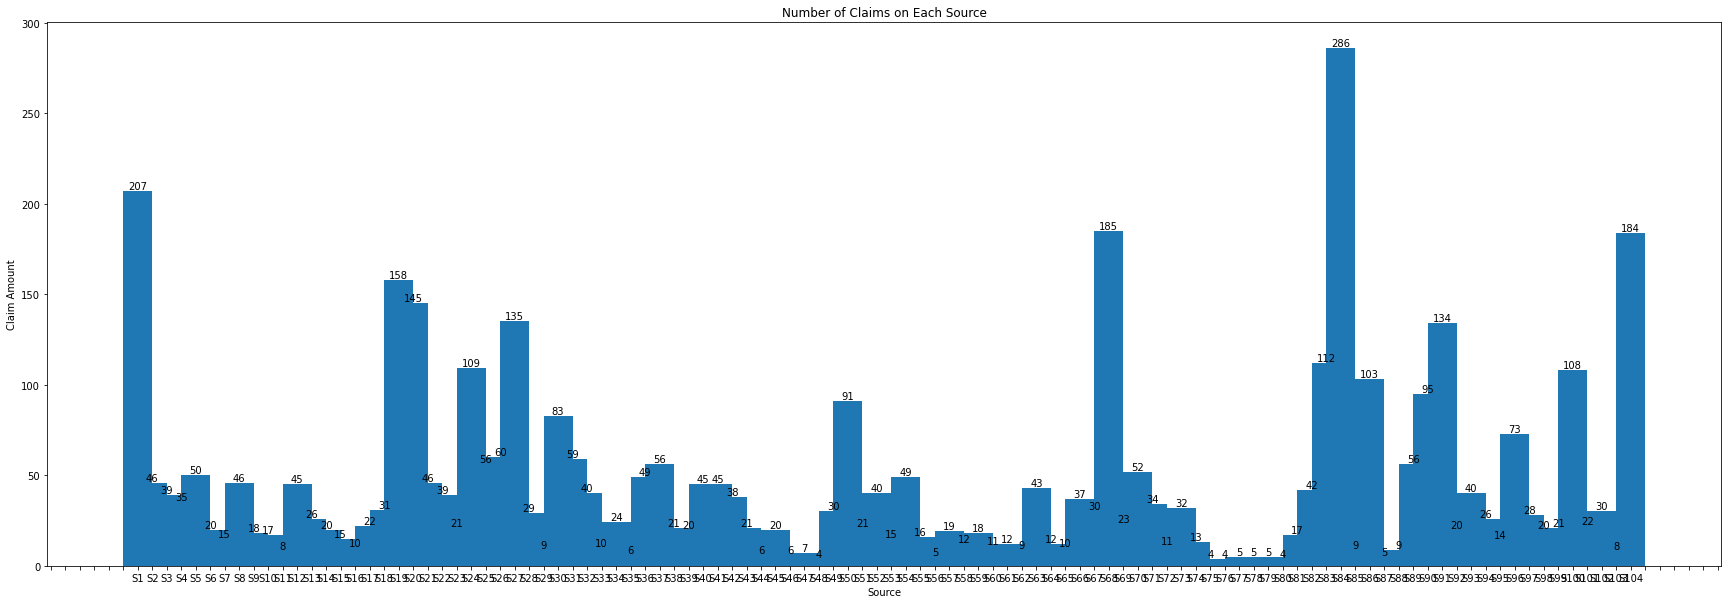

In [ ]:
fig, ax = plt.subplots(figsize=(30,10))
#fig = plt.figure(figsize=(50,10))
#ax = fig.add_subplot(321)
source = ['S' + str(i+1) for i in range(len(sc['source_url']))]
source_claims = sc['size']
bars = ax.bar(source, source_claims, width=2)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
for bar in bars:
  height = bar.get_height()
  label_x_pos = bar.get_x() + bar.get_width() / 2
  ax.text(label_x_pos, height, s=f'{height}', ha='center',
  va='bottom')

plt.title('Number of Claims on Each Source')
plt.xlabel('Source')
plt.ylabel('Claim Amount')
plt.show()

In [ ]:
model = TruthDiscovery()

In [ ]:
source_list = data["source_url"].drop_duplicates().values.tolist()
claim_list = data["idiom_claims"].drop_duplicates().values.tolist()

In [ ]:
k = model.one_hot_encoding(source_list, claim_list, data)[1]
k

,source_url,adu mulut,akal bulus,ambang pintu,anak bawang,anak buah,anak emas,anak semata wayang,angkat bicara,angkat kaki,...,jalan serong,jurang kehidupan,kambing congek,kandang harimau,kepala berat,ebar mulut,masuk angin,mengasah pikiran,tebal kulit,tebal lidah
0,https://salamadian.com/contoh-ungkapan-bahasa-...,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,1,0,0,0,0
1,https://dosenbahasa.com/idiom,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,https://dosenbahasa.com/jenis-jenis-idiom-dala...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,https://dosenbahasa.com/contoh-ungkapan-besert...,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,https://dosenbahasa.com/contoh-makna-kias,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,http://p2k.unhamzah.ac.id/ind/3073-2970/Daftar...,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
100,https://www.ayo-berbahasa.id/2020/11/contoh-fr...,0,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
101,https://brainly.co.id/tugas/17873723/,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
102,https://majalahpendidikan.com/contoh-frasa-idi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Training

In [ ]:
train = model.fit(df=data, factor=0.5, isAvgLog=True, iteration=3)

In [ ]:
train

,source_web,source_url,idiom_claims,trustworthiness_score,belief_score
0,salamadian.com,https://salamadian.com/contoh-ungkapan-bahasa-...,adu mulut,0.882826,0.666724
1,salamadian.com,https://salamadian.com/contoh-ungkapan-bahasa-...,akal bulus,0.882826,0.466138
2,salamadian.com,https://salamadian.com/contoh-ungkapan-bahasa-...,ambang pintu,0.882826,0.125302
3,salamadian.com,https://salamadian.com/contoh-ungkapan-bahasa-...,anak bawang,0.882826,0.605789
4,salamadian.com,https://salamadian.com/contoh-ungkapan-bahasa-...,anak buah,0.882826,0.733229
...,...,...,...,...,...
4351,id.wiktionary.org,https://id.wiktionary.org/wiki/Kategori:id:Ist...,tebal telinga,0.567089,0.283966
4352,id.wiktionary.org,https://id.wiktionary.org/wiki/Kategori:id:Ist...,ujung hidung,0.567089,0.039750
4353,id.wiktionary.org,https://id.wiktionary.org/wiki/Kategori:id:Ist...,ujung kuku,0.567089,0.039750
4354,id.wiktionary.org,https://id.wiktionary.org/wiki/Kategori:id:Ist...,ujung pangkal,0.567089,0.039750


# Testing

Data Test Link : https://drive.google.com/file/d/149oVxg_kjfZmYGNka3DVzN9hz_wOLQc5/view?usp=sharing

In [ ]:
gdd.download_file_from_google_drive(file_id='149oVxg_kjfZmYGNka3DVzN9hz_wOLQc5',
                                    dest_path='content/Frasa_bahasa_indonesia.zip',
                                    unzip=True)

Unzipping...Done.


In [ ]:
data_test = pd.read_csv("/content/content/Frasa_bahasa_indonesia/Frasa_bahasa_indonesia.csv")
data_test

,frasa,label
0,abad keemasan,frasa biasa
1,abu tulang,frasa biasa
2,adem ayem,frasa biasa
3,adik bungsu,frasa biasa
4,adik ipar,frasa biasa
...,...,...
995,bermuka masam,frasa idiom
996,bermental baja,frasa idiom
997,bunga bank,frasa idiom
998,adu domba,frasa idiom


In [ ]:
label = data_test["label"].drop_duplicates().values.tolist()
label

['frasa biasa', 'frasa idiom']

In [ ]:
data_test['frasa'] = data_test['frasa'].str.casefold()
data_test['frasa'] = data_test['frasa'].str.strip()

In [ ]:
data_test.groupby(['label']).size()

label
frasa biasa    445
frasa idiom    555
dtype: int64

In [ ]:
label_cat = {"label":{'frasa biasa' : 0, 'frasa idiom' : 1}}
data_test = data_test.replace(label_cat)
data_test

,frasa,label
0,abad keemasan,0
1,abu tulang,0
2,adem ayem,0
3,adik bungsu,0
4,adik ipar,0
...,...,...
995,bermuka masam,1
996,bermental baja,1
997,bunga bank,1
998,adu domba,1


In [ ]:
X = data_test["frasa"].values.tolist()
X[:5]

['abad keemasan', 'abu tulang', 'adem ayem', 'adik bungsu', 'adik ipar']

In [ ]:
Y = data_test["label"].values.tolist()
Y[:5]

[0, 0, 0, 0, 0]

In [ ]:
print(len(X))
print(len(Y))

1000
1000


In [ ]:
predicted_label = model.predict(X)

In [ ]:
predicted_label[:5]

[0, 0, 0, 0, 0]

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
print(classification_report(Y, predicted_label, target_names=label))
pd.DataFrame(confusion_matrix(Y, predicted_label), index=label, columns=label)

              precision    recall  f1-score   support

 frasa biasa       0.83      0.85      0.84       445
 frasa idiom       0.88      0.86      0.87       555

    accuracy                           0.86      1000
   macro avg       0.85      0.86      0.85      1000
weighted avg       0.86      0.86      0.86      1000



,frasa biasa,frasa idiom
frasa biasa,377,68
frasa idiom,76,479


In [ ]:
print('Accuracy:', accuracy_score(Y, predicted_label))
print('F1 score:', f1_score(Y, predicted_label))
print('Recall:', recall_score(Y, predicted_label))
print('Precision:', precision_score(Y, predicted_label))

Accuracy: 0.856
F1 score: 0.8693284936479129
Recall: 0.863063063063063
Precision: 0.8756855575868373


In [ ]:
accuracy = round((accuracy_score(Y, predicted_label)*100), 2)
f1_score = round((f1_score(Y, predicted_label)*100), 2)
recall = round((recall_score(Y, predicted_label)*100), 2)
precision = round((precision_score(Y, predicted_label)*100), 2)
list_val = [[accuracy, precision, recall, f1_score]]
evaluasi = pd.DataFrame(list_val,
                        columns=['accuracy', 'precision', 'recall', 'f1_score'])
evaluasi

,accuracy,precision,recall,f1_score
0,85.6,87.57,86.31,86.93


In [ ]:
pred = model.predict(['berputih tulang'])
pred

[1]

In [ ]:
import dill
# save model
filename = 'truth_discovery.dill'
with open(filename, 'wb') as f:
    dill.dump(model, f)

In [ ]:
# load model
with open(filename, 'rb') as f:
    td_model = dill.load(f)

In [ ]:
pred = td_model.predict(['anak bawang'])
pred

[1]